In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution
from keras.models import Model, load_model
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy, kl_divergence
from keras.losses import MeanSquaredError as mse
from keras import optimizers

from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

from argparse import Namespace
from pathlib import Path
from collections import OrderedDict
import sklearn
from sklearn import preprocessing
import os
import pickle
from utils.functions import sample, get_error_term
from model.vae_model import vae_model

In [2]:
raw_dt = pd.read_csv("data/realTweets/realTweets/Twitter_volume_CRM.csv")
# raw_dt = pd.read_csv(datafile_path)
raw_dt.head()

,timestamp,value
0,2015-02-26 21:42:53,11
1,2015-02-26 21:47:53,10
2,2015-02-26 21:52:53,3
3,2015-02-26 21:57:53,4
4,2015-02-26 22:02:53,9


Text(0.5, 1.0, 'Original Dataset')

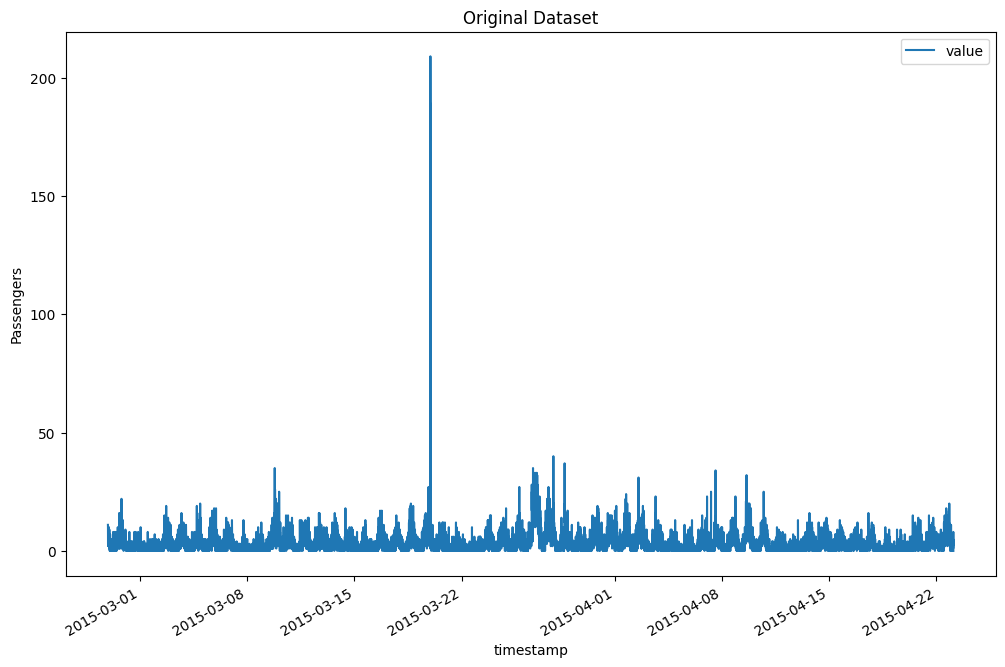

In [3]:
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(12, 8))
plt.ylabel("Passengers")
plt.title("Original Dataset")

In [4]:
data['label'] = 0
with open('lists.pkl', 'rb') as f:
    lists = pickle.load(f)

# Access the lists
instances= lists[1]

In [5]:
for i in range(len(instances)): 
    start = pd.to_datetime(instances[i][0])
    end = pd.to_datetime(instances[i][1])
    data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'label'] = 1

In [6]:
data_w_ts=data.copy()
data_w_ts

,timestamp,value,label
0,2015-02-26 21:42:53,11,0
1,2015-02-26 21:47:53,10,0
2,2015-02-26 21:52:53,3,0
3,2015-02-26 21:57:53,4,0
4,2015-02-26 22:02:53,9,0
...,...,...,...
15897,2015-04-23 02:27:53,1,0
15898,2015-04-23 02:32:53,4,0
15899,2015-04-23 02:37:53,3,0
15900,2015-04-23 02:42:53,8,0


In [7]:
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['hour_min'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

data['day_of_week'] = data['timestamp'].dt.dayofweek
data.head()

,timestamp,value,label,day,month,hour_min,day_of_week
0,2015-02-26 21:42:53,11,0,26,2,21.700000,3
1,2015-02-26 21:47:53,10,0,26,2,21.783333,3
2,2015-02-26 21:52:53,3,0,26,2,21.866667,3
3,2015-02-26 21:57:53,4,0,26,2,21.950000,3
4,2015-02-26 22:02:53,9,0,26,2,22.033333,3


In [8]:
cont_vars = ['value', 'hour_min']
cat_vars = ['day', 'month', 'day_of_week']
data.drop('timestamp', axis=1, inplace=True)

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in cat_vars] 
for col, enc in zip(cat_vars, label_encoders):
    data[col] = enc.fit_transform(data[col])
    
data= pd.get_dummies(data.iloc[:,:], columns= cat_vars )
data

,value,label,hour_min,day_0,day_1,day_2,day_3,day_4,day_5,day_6,...,month_0,month_1,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,11,0,21.700000,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
1,10,0,21.783333,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
2,3,0,21.866667,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
3,4,0,21.950000,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
4,9,0,22.033333,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15897,1,0,2.450000,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15898,4,0,2.533333,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15899,3,0,2.616667,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15900,8,0,2.700000,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False


In [10]:
print(data.keys())

Index(['value', 'label', 'hour_min', 'day_0', 'day_1', 'day_2', 'day_3',
       'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24',
       'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'month_0',
       'month_1', 'month_2', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6'],
      dtype='object')


In [11]:
# Splitting to train and test
test_ratio =0.6
tr_data = data.iloc[int(len(data) * test_ratio) :]
tst_data = data.iloc[: int(len(data) * test_ratio)]

In [12]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])

In [13]:
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

In [14]:
tr_data_scaled

,value,label,hour_min,day_0,day_1,day_2,day_3,day_4,day_5,day_6,...,month_0,month_1,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
9541,-0.022741,0,-1.608309,True,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9542,0.280521,0,-1.596308,True,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9543,-0.629266,0,-1.584307,True,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9544,0.280521,0,-1.572307,True,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9545,0.887047,0,-1.560306,True,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15897,-0.629266,0,-1.368296,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15898,0.280521,0,-1.356295,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15899,-0.022741,0,-1.344295,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15900,1.493572,0,-1.332294,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False


In [15]:
tst_data_scaled

,value,label,hour_min,day_0,day_1,day_2,day_3,day_4,day_5,day_6,...,month_0,month_1,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,2.403359,0,1.403852,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
1,2.100097,0,1.415853,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
2,-0.022741,0,1.427854,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
3,0.280521,0,1.439854,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
4,1.796834,0,1.451855,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9536,4.222935,0,-1.668312,True,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9537,3.919672,0,-1.656311,True,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9538,2.100097,0,-1.644311,True,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9539,1.796834,0,-1.632310,True,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False


In [16]:
train = tr_data_scaled[tr_data_scaled.label != 1]
train= train.drop(columns=['label'])
train

,value,hour_min,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,...,month_0,month_1,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
9541,-0.022741,-1.608309,True,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9542,0.280521,-1.596308,True,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9543,-0.629266,-1.584307,True,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9544,0.280521,-1.572307,True,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
9545,0.887047,-1.560306,True,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15897,-0.629266,-1.368296,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15898,0.280521,-1.356295,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15899,-0.022741,-1.344295,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15900,1.493572,-1.332294,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False


In [17]:
labels_of_test = tst_data_scaled['label'].tolist()
test= tst_data_scaled.drop(columns=['label'])

In [18]:
#Converting df to arrays
train= train.to_numpy()
train= np.asarray(train).astype(np.float32)
test= test.to_numpy()
test= np.asarray(test).astype(np.float32)

In [19]:
vae_model = vae_model(train)

vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(train,train, 
                        shuffle=True,
                        epochs=1000,
                        batch_size=128,
                        validation_split=0.2,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])


Model: "vae_mlp"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 43)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 14)        │      1,540 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 21)        │        924 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 43)        │      1,261 │ encoder[0][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 14)        │        308 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 14)        │        308 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer      │ (None, 43)        │          0 │ encoder_input[0]… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,801 (10.94 KB)

 Trainable params: 2,801 (10.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1789.6017 - val_loss: 1706.3385
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1736.1133 - val_loss: 1651.9451
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1682.6071 - val_loss: 1601.3314
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1635.6915 - val_loss: 1557.8618
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1590.0037 - val_loss: 1509.8993
Epoch 6/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1538.7621 - val_loss: 1468.1176
Epoch 7/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1485.4222 - val_loss: 1425.9723
Epoch 8/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1442.2278 - val_loss: 1384.9553
Epoch 9/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1403.5953 - val_loss: 1335.5383
Epoch 10/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1355.1270 - val_loss: 1290.7742
Epoch 11/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1310.5482 - val_lo

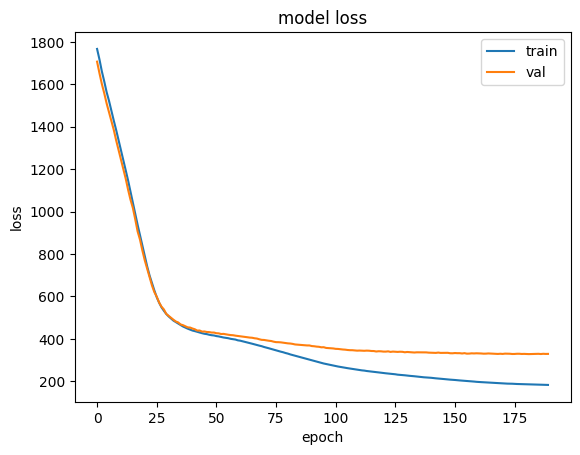

In [20]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [21]:
train_pred = vae_model.predict(train)[0]

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step


In [22]:
mae_vector = get_error_term(train_pred, train, _rmse=True)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}')
error_thresh = np.max(mae_vector) -0.01
print(f'setting threshold on {error_thresh} ')

Avg error 0.16178977489471436
median error 0.15805500745773315
setting threshold on 1.2761548662185669 


(array([258., 716., 563., 731., 449., 667., 726., 710., 558., 437., 248.,
        137.,  54.,  29.,   8.,   9.,   6.,  10.,   3.,   1.,   8.,   1.,
          3.,   1.,   4.,   1.,   4.,   1.,   2.,   4.,   0.,   3.,   0.,
          3.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   2.,   0.,   0.,   1.]),
 array([0.01457067, 0.04000236, 0.06543404, 0.09086572, 0.11629741,
        0.14172909, 0.16716078, 0.19259246, 0.21802415, 0.24345583,
        0.26888752, 0.29431918, 0.31975088, 0.34518257, 0.37061426,
        0.39604592, 0.42147762, 0.44690931, 0.47234097, 0.49777266,
        0.52320433, 0.54863602, 0.57406771, 0.5994994 , 0.6249311 ,
        0.65036279, 0.67579448, 0.70122612, 0.72665781, 0.7520895 ,
        0.77752119, 0.80295289, 0.82838458, 0.85381621, 0.8792479 ,
        0.9046796 , 0.93011129, 0.95554298, 0.98097467, 1.00640631,
        1.03183806, 1.05726969, 1.08270144, 1.10813308, 1.13356471,
        1.15899646, 1.1844281 , 1.20985985, 1.

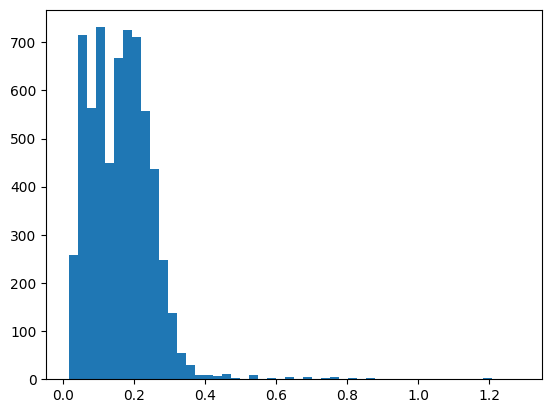

In [23]:
plt.hist(mae_vector, bins=50)

In [24]:
#Actual ratio of anomalies 
ratio=np.count_nonzero(labels_of_test) / len(labels_of_test)
print(ratio)

0.16696363064668274


In [25]:
pred = vae_model.predict(test)[0]
mae_vector_test = get_error_term(pred, test, _rmse=True)
print(f'Avg error {np.mean(mae_vector_test)}\nmedian error {np.median(mae_vector_test)}')
anomalies = (mae_vector_test > (error_thresh))

np.count_nonzero(anomalies) / len(anomalies)

299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Avg error 0.3422417640686035
median error 0.32568708062171936


0.0009432973482863432

(array([9.033e+03, 3.730e+02, 8.100e+01, 2.900e+01, 1.000e+01, 6.000e+00,
        3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.23219682, 0.41508004, 0.59796321, 0.78084642, 0.96372962,
        1.14661288, 1.32949603, 1.51237929, 1.69526243, 1.87814569,
        2.06102896, 2.24391198, 2.42679524, 2.60967851, 2.79256177,
        2.97544479, 3.15832806, 3.34121132, 3.52409458, 3.70697761,
        3.88986087, 4.07274389, 4.25562716, 4.43851042, 4.62139368,
        4.80427694, 4.98716021, 5.17

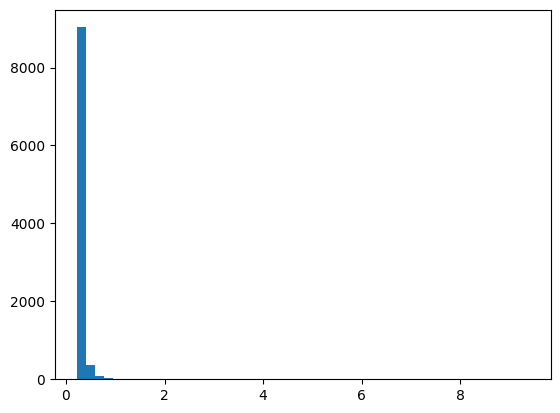

In [26]:
plt.hist(mae_vector_test, bins=50)

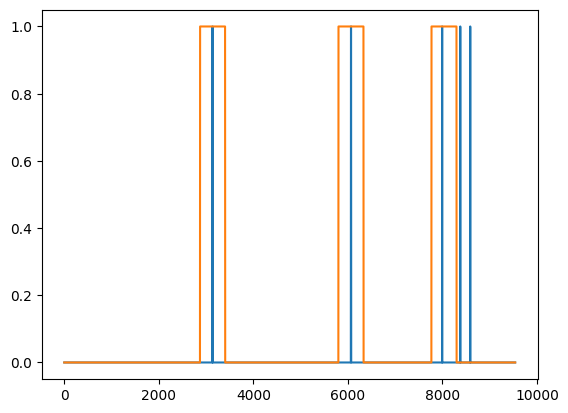

In [27]:
plt.plot(anomalies)
plt.plot(labels_of_test)

In [28]:
from sklearn.metrics import classification_report
# y_test contains the labels of anomaly =1
print(classification_report(np.logical_not(labels_of_test), anomalies))

              precision    recall  f1-score   support

       False       0.17      1.00      0.29      1593
        True       0.22      0.00      0.00      7948

    accuracy                           0.17      9541
   macro avg       0.19      0.50      0.14      9541
weighted avg       0.21      0.17      0.05      9541



In [29]:
tst_data['anomaly']=anomalies
df = data_w_ts['timestamp']
ts = df.iloc[: int(len(data) * test_ratio)]
tst_data['timestamp']=ts
tst_data = tst_data[['timestamp','value', 'label','anomaly']]

C:\Users\99anj\AppData\Local\Temp\ipykernel_39168\964305341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_data['anomaly']=anomalies
C:\Users\99anj\AppData\Local\Temp\ipykernel_39168\964305341.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_data['timestamp']=ts


Text(0.5, 1.0, 'Location of the Anomalies on the Time Series, Test Period')

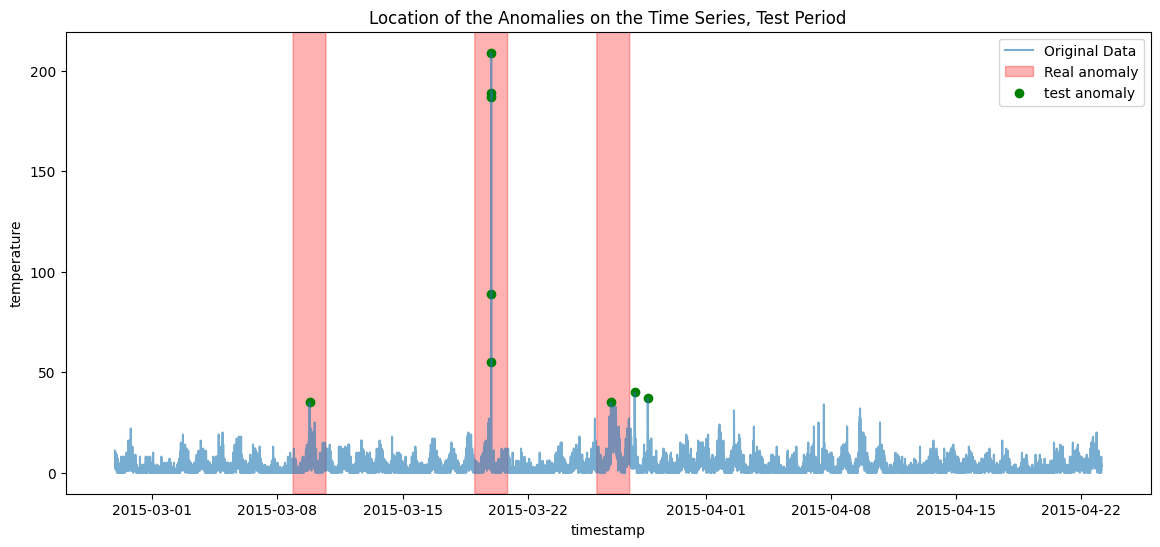

In [30]:
anomalies_ts = data_w_ts.loc[data_w_ts['label']==1, ('timestamp', 'value')]
testing = tst_data.loc[tst_data['anomaly']==True, ('timestamp', 'value')]
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data_w_ts['timestamp'], data_w_ts['value'], label='Original Data', alpha=0.6)
ax.fill_between(data_w_ts['timestamp'], 0, 1, where=data_w_ts['label'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(),label='Real anomaly')
#ax.scatter(anomalies_ts['timestamp'], anomalies_ts['value'], color='red', label='Realll anomaly')
ax.scatter(testing['timestamp'], testing['value'], color='green', label='test anomaly')
plt.legend()
plt.xlabel("timestamp")
plt.ylabel("temperature")
plt.title("Location of the Anomalies on the Time Series, Test Period")